In [1]:
import pandas as pd
import numpy as np

In [2]:
# This will allow you to see all column names & rows when you are doing .head(). None of the column name will be truncated.
# source: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
# source: https://gist.github.com/rozanecm/38f2901c592bdffc40726cb0473318cf
# Function which plays a beep of given duration and frequency.
# Useful for when executing things that need a while to finish, to get notified.
import os
def beep(duration = 1, freq = 1500):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [4]:
train = pd.read_csv('../data/train.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha']
#                     , nrows=1000
                   )
test = pd.read_csv('../data/test.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])
sample_submission = pd.read_csv('../data/ejemploRespuesta.csv')

In [5]:
rescued_coords = pd.read_csv('../data/rescueLatLongs.csv')
precios_en_dolares = pd.read_csv('../data/precios_en_dolares.csv')

In [6]:
# mergeamos con coords. extra obtenidas en tp1.
train = train.merge(rescued_coords.drop('Unnamed: 0', axis=1), how='left', on='id')
train['lat_x'] = train.apply(lambda x: x['lat_y'] if pd.isna(x['lat_x']) else x['lat_x'], axis=1)
train['lng_x'] = train.apply(lambda x: x['lng_y'] if pd.isna(x['lng_x']) else x['lng_x'], axis=1)
train.drop(['lat_y','lng_y'], axis=1, inplace=True)
train.rename(columns={'lat_x':'lat','lng_x':'lon'}, inplace=True)

# por consistencia, para que ambos datasets tengan mismos nombres
test.rename(columns={'lng':'lon'}, inplace=True)
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lon,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23536.0,31.733330,-106.48333,2015-08-23,False,False,False,False,False,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24512.0,19.312500,-99.25000,2013-06-28,False,False,False,True,True,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,2.0,144.0,166.0,48544.0,NaN,NaN,2015-10-17,False,False,False,False,False,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,1.0,63.0,67.0,53664.0,19.296875,-99.68750,2012-03-09,False,False,False,True,True,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,1.0,95.0,95.0,47840.0,20.723560,-103.38479,2016-06-07,False,False,False,False,False,1150000.0


In [7]:
# inf. values don't make sense. I think it's preferable to treat them as nans directly.
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Agregamos features que ya hemos creado para analisis de tp1

In [8]:
def contar_amenities(row):
    return row['gimnasio'] + row['usosmultiples'] + row['piscina'] + row['escuelascercanas'] + row['centroscomercialescercanos']

In [9]:
train['cant_amenities'] = train.apply(lambda x: contar_amenities(x), axis=1)
test['cant_amenities'] = test.apply(lambda x: contar_amenities(x), axis=1)

In [10]:
def feature_fechas(df):
    # Para entender lo de los senos y cosenos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['cos_month'] = np.cos(2*np.pi*df['month']/12)
    # tomo cant. de dias en mes: 31 en todos los casos. Para esto deberia servir bastante bien igual.
    df['sin_day'] = np.sin(2*np.pi*df['day']/31)
    df['cos_day'] = np.cos(2*np.pi*df['day']/31)
    
    # no necesito mas las cols. originales de month y day.
    df.drop(['month','day'], axis=1, inplace=True)
    
feature_fechas(train)
feature_fechas(test)

In [11]:
palabras_avenida = ['avenida', 'av']
train['es_avenida'] = train['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))
test['es_avenida'] = test['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))

# * Fin agregado de features de tp1 *

El sample submission no tiene header. **Ojo con eso al guardar la submission.** Hagamos la funcion para guardar submissions ahora, para evitar problemas a futuro y despreocuparnos.

In [12]:
# To save predictions.
# There must be a directory ../predictions for this to work as expected.
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
import time
def _get_filename(my_name, timestamp):
    return "../predictions/" + timestamp + " by " + my_name + ".csv"

def _save_description(authors_name, timestamp, submission_description):
    f = open("../predictions/" + authors_name + ".txt","a")
    f.write(timestamp + ": " + submission_description + '\n')
    f.close()

def save_submission(submission_df, authors_name="rozanecm", description = "no description.", index=False, header=True):
    timestamp = time.strftime("%Y.%m.%d - %H:%M:%S")
    submission_df.to_csv(_get_filename(authors_name, timestamp), index=index, header=header)
    _save_description(authors_name, timestamp, description)

In [13]:
# Define a seed, so all algorithms that accept a seed, take the same, for consistency reasons,
# so everything can be replicated without problems random state
seed=42

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('precio', axis=1), train['precio'], test_size=0.33, random_state=seed)

# Approach 1

## Entrenamiento local

In [14]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
cat_columns = ['tipodepropiedad','ciudad','provincia']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer

transformers = []

# transformers.append(("cat",
#                      Pipeline(steps=[
#                          ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                          ("one_hot", OneHotEncoder(handle_unknown='ignore')),
#                      ]),
#                      cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.0s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.3min
773329.9676150936


## Entrenamiento con todos los datos para obtener predicciones a subir

In [15]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.3s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.2min


In [16]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [85]:
# save_submission(df, description="first approach. Not taking any text atts. Random forest.")

In [17]:
description = "repeat first approach. This time, train with all the data. On previous runs, I trianed only with X_test, which is a part of the whole given train set."
save_submission(df, description=description)

In [19]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [34]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], 'approach_1':y_scores}))

df.to_csv('../predictions/on_train_data/approach_1',index=False, header=True)

in loop 1
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.2min
773727.6079705233
in loop 1
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.6s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.5min
768614.1229419869
in loop 1
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.8s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 1.5min
765473.7160576448


In [35]:
beep()

# Approach 2

### Estudio var cat.: tipodepropiedad

In [102]:
enc = OneHotEncoder(handle_unknown='ignore')
aux = enc.fit_transform(train[['tipodepropiedad']].dropna())

In [103]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=22, n_iter=7, random_state=42)
svd.fit(aux)

TruncatedSVD(algorithm='randomized', n_components=22, n_iter=7, random_state=42,
             tol=0.0)

In [118]:
total_energy = np.sum(svd.singular_values_)
accumulated_energy = 0
i = 1
for singular_value in svd.singular_values_:
    accumulated_energy += singular_value
    print('current singular value:', singular_value)
    print("accumulated energy (%) till singular value n.", i, ":", accumulated_energy/total_energy)
    print("")
    i += 1

current singular value: 376.4531843397733
accumulated energy (%) till singular value n. 1 : 0.3058768243388757

current singular value: 239.45980873630234
accumulated energy (%) till singular value n. 2 : 0.5004433970231067

current singular value: 138.91364223860808
accumulated energy (%) till singular value n. 3 : 0.613313909248451

current singular value: 99.72462083154932
accumulated energy (%) till singular value n. 4 : 0.6943424450592185

current singular value: 55.27205442173929
accumulated energy (%) till singular value n. 5 : 0.7392522537273476

current singular value: 41.72529209005007
accumulated energy (%) till singular value n. 6 : 0.7731550080937372

current singular value: 37.49666651850506
accumulated energy (%) till singular value n. 7 : 0.803621907445616

current singular value: 37.36308338453927
accumulated energy (%) till singular value n. 8 : 0.8339802674451864

current singular value: 36.41428291206578
accumulated energy (%) till singular value n. 9 : 0.8635677053

Con el 11avo vs se retiene el 90% de la energia de la matriz, que es lo recomendado por Leskovec et al en su libro MMDS. Sin embargo, con el metodo grafico, se observa un codo con 6 valores ya. A pesar de esto, se elige 11 porque alli hay una especia de segundo codo, aunque un poco menor.

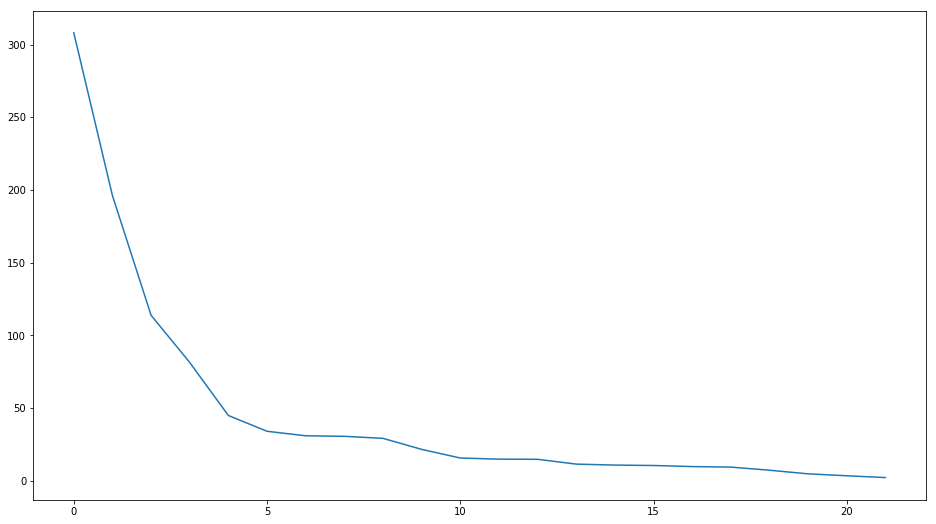

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(svd.singular_values_)
plt.show()

### Estudio var cat.: provincia

In [119]:
enc = OneHotEncoder(handle_unknown='ignore')
aux = enc.fit_transform(train[['provincia']].dropna())

In [120]:
aux

<239845x32 sparse matrix of type '<class 'numpy.float64'>'
	with 239845 stored elements in Compressed Sparse Row format>

In [122]:
from sklearn.decomposition import TruncatedSVD
# me quedo con todas las componentes para poder analizar cuantas dimensiones conviene retener
svd = TruncatedSVD(n_components=31, n_iter=7, random_state=42)
svd.fit(aux)

TruncatedSVD(algorithm='randomized', n_components=31, n_iter=7, random_state=42,
             tol=0.0)

In [123]:
total_energy = np.sum(svd.singular_values_)
accumulated_energy = 0
i = 1
for singular_value in svd.singular_values_:
    accumulated_energy += singular_value
    print('current singular value:', singular_value)
    print("accumulated energy (%) till singular value n.", i, ":", accumulated_energy/total_energy)
    print("")
    i += 1

current singular value: 242.46649253054727
accumulated energy (%) till singular value n. 1 : 0.1086471680396908

current singular value: 203.97793998381113
accumulated energy (%) till singular value n. 2 : 0.20004794383562494

current singular value: 145.7326318982503
accumulated energy (%) till singular value n. 3 : 0.2653494936764584

current singular value: 130.33802208101685
accumulated energy (%) till singular value n. 4 : 0.3237528501122475

current singular value: 123.79014500352044
accumulated energy (%) till singular value n. 5 : 0.37922215865664666

current singular value: 102.08329931973996
accumulated energy (%) till singular value n. 6 : 0.42496481472216685

current singular value: 91.90756225686378
accumulated energy (%) till singular value n. 7 : 0.4661478097678917

current singular value: 89.03931715819687
accumulated energy (%) till singular value n. 8 : 0.5060455686394899

current singular value: 85.65628990331258
accumulated energy (%) till singular value n. 9 : 0.54

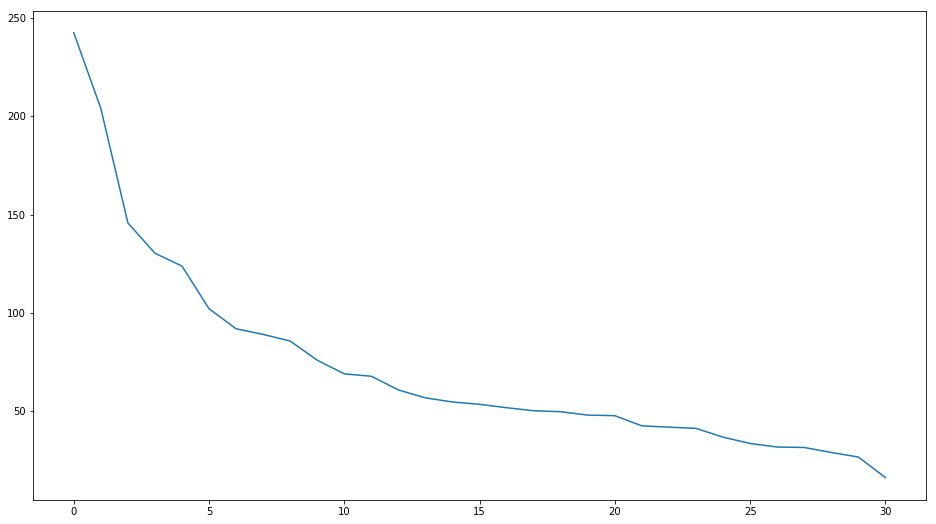

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(svd.singular_values_)
plt.show()

Segun las cuentas deberiamos retener 24 vs para retener el 90% de la energia. Como el total es 32, este nro. parece ser un poco excesivo. Por el metodo grafico se decide tomar nuevamente 11.

### Estudio var cat.: ciudad

In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
aux = enc.fit_transform(train[['ciudad']].dropna())

In [16]:
aux

<239628x875 sparse matrix of type '<class 'numpy.float64'>'
	with 239628 stored elements in Compressed Sparse Row format>

Como no se puede calcular la svd de todos los componentes para obtener los valores singulares, se elige tomar 100 dimensiones.

## Entrenamiento local

In [22]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
# for col in text_columns:
#     # First, fill empty texts with an empty string.
#     X_train[col] = X_train[col].fillna("")
#     X_test[col] = X_test[col].fillna("")
#     transformer_name = "text_" + col
#     transformers.append((transformer_name,
#                         Pipeline(steps=[
#     #                         ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
#                             ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
# #                                                                      ngram_range=(2,5)
#                                                                     )),
#     #                         se podria agregar una svd.... o alguna proyeccion... 
#                         ]),
#                          col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.4s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 2.7min
619151.4739815602


In [23]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [24]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   6.6s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 4.6min


In [25]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [26]:
description = "Second approach. Same as previous, but adding categorical features with one hot encoding + svd dim. red., to 11 dimensions in the small cases, and to 100 in the larger one. Algorithm is same as previously."
save_submission(df, description=description)

In [27]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [29]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_2"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.5s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 3.1min
613617.4667506837
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   8.0s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 3.0min
619893.2199777354
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   5.7s
[Pipeline] ............... (step 2 of 2) Processing rfr, total= 3.0min
611674.0503883368


In [30]:
beep()

# Approach 3. Texto.

## Entrenamiento local

In [17]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida']

text_columns = ['titulo'
                ,'descripcion'
                ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

# The reason this for is necessary is because text transformers take an array-like parameter.
# If we pass a list of columns, then the transformer will receive a dataframe, and that will result in error.
# If you don't want to process all the text columns with the same pipeline, you'll have to define
# a different pipelines for each, and pass a different list for each of the pipelines.
# for col in text_columns_titulo:
for col in text_columns:
    # First, fill empty texts with an empty string.
    X_train[col] = X_train[col].fillna("")
    X_test[col] = X_test[col].fillna("")
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")
    transformer_name = "text_" + col
    transformers.append((transformer_name,
                        Pipeline(steps=[
#                             ("text_imputer", SimpleImputer(strategy='constant', fill_value="")),
                            ("hashing_vectorizer", HashingVectorizer(decode_error='replace', strip_accents='ascii', 
#                                                                      ngram_range=(2,5)
                                                                    )),
                            ("svd", TruncatedSVD(n_components=20, n_iter=7, random_state=seed))
    #                         se podria agregar una svd.... o alguna proyeccion... 
                        ]),
                         col))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))

from sklearn.ensemble import RandomForestRegressor
steps.append(("rfr", RandomForestRegressor(n_estimators=100,
    n_jobs=-1,
    random_state=seed)))

my_pipe = Pipeline(steps, verbose=True)

# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.0min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=14.4min
632879.1185852172


In [18]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [20]:
del X_train
del X_test
del y_train
del y_test

In [21]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.5min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=19.3min


In [22]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [23]:
description = "Third approach. Same as previous, but adding text features with one hashing vectorizer + svd dim. red. Algorithm is same as previously."
save_submission(df, description=description)

In [24]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [25]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_3"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['precio'],axis=1).iloc[train_index], train.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=14.1min
627943.7597431771
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.8min
633384.3494840289
[Pipeline] ......... (step 1 of 2) Processing col_trans, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing rfr, total=12.2min
624686.8034252054


In [30]:
beep()